In [1]:
%run setting.ipynb

In [2]:
import os
import re
import pandas as pd
from pandasql import sqldf
import yfinance as yf

pysqldf = lambda q: sqldf(q, globals())

In [3]:
import numpy as np
from sklearn.linear_model import LinearRegression
import plotly.express as px

# configuration

In [4]:
leverage_ratio = 2

ETF = 'NDX'
ETF_3x = 'QLD'

# data loading

## QQQ

qqq = yf.Ticker(ETF).history(
    period='max', 
    interval='1d', 
    actions=False)

In [5]:
qqq =  pd.read_csv(f'^NDX.csv', )

In [6]:
qqq = qqq.reset_index()
qqq['id'] = qqq.index
qqq['Date'] = pd.to_datetime(qqq['Date']).dt.date

In [7]:
qqq.head(2)

index        Date        Open        High         Low       Close  \
0      0  1985-10-01  110.620003  112.160004  110.565002  112.139999   
1      1  1985-10-02  112.139999  112.540001  110.779999  110.824997   

    Adj Close     Volume  id  
0  112.139999  153160000   0  
1  110.824997  164640000   1

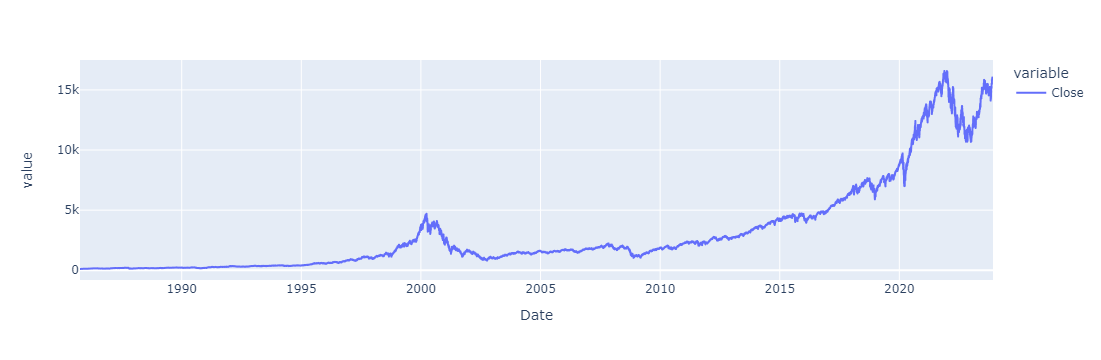

In [34]:
fig = px.line(qqq, x='Date', y=["Close"])
fig.show()

In [9]:
len(qqq)

9621

## QLD

data_3x = yf.Ticker(ETF_3x).history(
    period='max', 
    interval='1d', 
    actions=False)

In [10]:
data_3x =  pd.read_csv(f'QLD.csv', )

In [11]:
data_3x = data_3x.reset_index()
data_3x['id'] = data_3x.index
data_3x['Date'] = pd.to_datetime(data_3x['Date']).dt.date

data_3x.head(2)

index        Date      Open      High       Low     Close  Adj Close  \
0      0  2006-06-21  2.280313  2.281250  2.254688  2.257813   1.978537   
1      1  2006-06-22  2.250000  2.254063  2.180625  2.204688   1.931983   

    Volume  id  
0   761600   0  
1  6806400   1

# daily percentage

In [12]:
qqq = pysqldf(u"""
    select qqq.*, 
    pre_day.Date as pre_Date,
    pre_day.Close as pre_Close,
    (qqq.Close - pre_day.Close)/pre_day.Close AS Percent    
    from qqq 
    left join qqq as pre_day on pre_day.id+1 = qqq.id
    order by qqq.Date asc
    """)

In [13]:
pysqldf(u"""
    select * 
    from qqq
    order by Date asc
    limit 2
    """)

index        Date        Open        High         Low       Close  \
0      0  1985-10-01  110.620003  112.160004  110.565002  112.139999   
1      1  1985-10-02  112.139999  112.540001  110.779999  110.824997   

    Adj Close     Volume  id    pre_Date   pre_Close   Percent  
0  112.139999  153160000   0        None         NaN       NaN  
1  110.824997  164640000   1  1985-10-01  112.139999 -0.011726

# simulation

In [14]:
data_list = pysqldf(u"""
    select 
    Date,
    Percent, 
    {}*Percent as Leveraged_Percent
    from qqq
    where Percent is not null
    """.format(leverage_ratio)).to_dict('records')

In [15]:
data_list[0:3]

[{'Date': '1985-10-02',
  'Percent': -0.011726431351225594,
  'Leveraged_Percent': -0.02345286270245119},
 {'Date': '1985-10-03',
  'Percent': 0.00040609971773787433,
  'Leveraged_Percent': 0.0008121994354757487},
 {'Date': '1985-10-04',
  'Percent': -0.007170614038857749,
  'Leveraged_Percent': -0.014341228077715498}]

In [16]:
start_price = qqq['Close'][0]

qqq_price = start_price
tqqq_price = start_price

for r in data_list:
    ###
    qqq_price = qqq_price*(1+r['Percent'])
    r['price'] = qqq_price
    ###
    tqqq_price = tqqq_price*(1+r['Leveraged_Percent'])    
    r['Leveraged_price'] = tqqq_price  

data1 = pd.DataFrame(data_list)

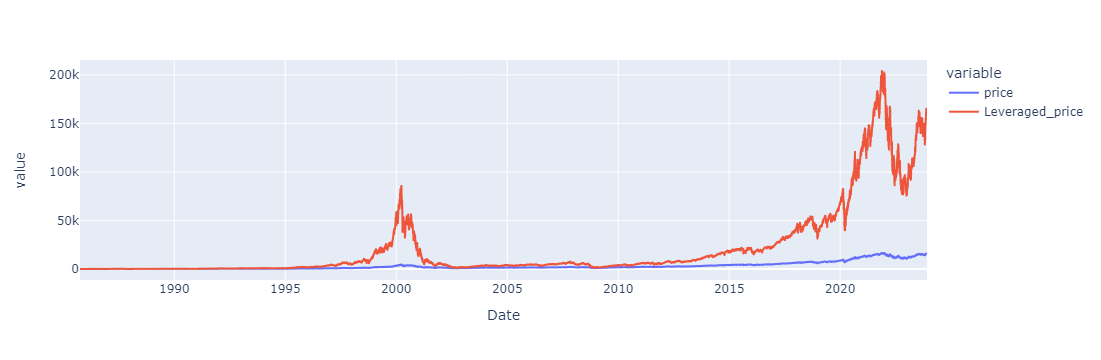

In [17]:
fig = px.line(data1, x='Date', y=[
    'price', 
    'Leveraged_price',
    ])
fig.show()

# regression

In [18]:
compare_3x = pysqldf(u"""
    select 
    data1.Date,
    data1.`Leveraged_price`,
    data_3x.Close
    from data_3x
    join data1 on data1.Date = data_3x.Date
    order by data1.Date asc
    """.format(leverage_ratio))

In [19]:
X = compare_3x['Leveraged_price'].to_numpy()
X = np.array([[i] for i in X])
y = compare_3x['Close'].to_numpy()

In [20]:
reg = LinearRegression().fit(X, y)

In [21]:
reg.score(X, y)

print(reg.coef_)

print(reg.intercept_)

[0.0004453]
0.3376298690839086


In [22]:
result = pysqldf(u"""
    select 
    Date,
    `Leveraged_price` * {} + {} AS simulated_Close,
    Close
    from compare_3x
    """.format(
    reg.coef_[0],
    reg.intercept_))

result.plot(x ='Date', y=[
    'simulated_Close', 
    'Close',
    ], grid = True)

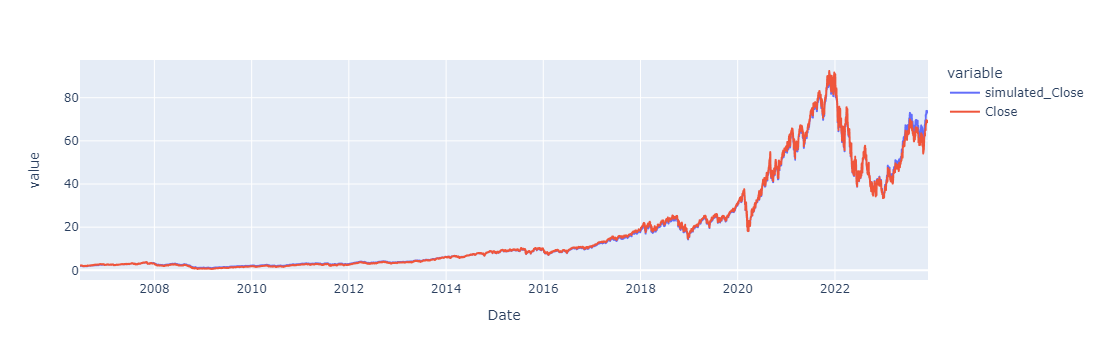

In [35]:
fig = px.line(result, x='Date', y=["simulated_Close",'Close'])
fig.show()

all simulation results

In [24]:
final_result = pysqldf(f"""
    select 
    data1.Date,
    data1.price AS {ETF},
    data1.`Leveraged_price` * {reg.coef_[0]} + {reg.intercept_} AS simulated_{ETF_3x},
    data_3x.Close as {ETF_3x}
    from data1
    left join data_3x on data_3x.Date = data1.Date
    """)

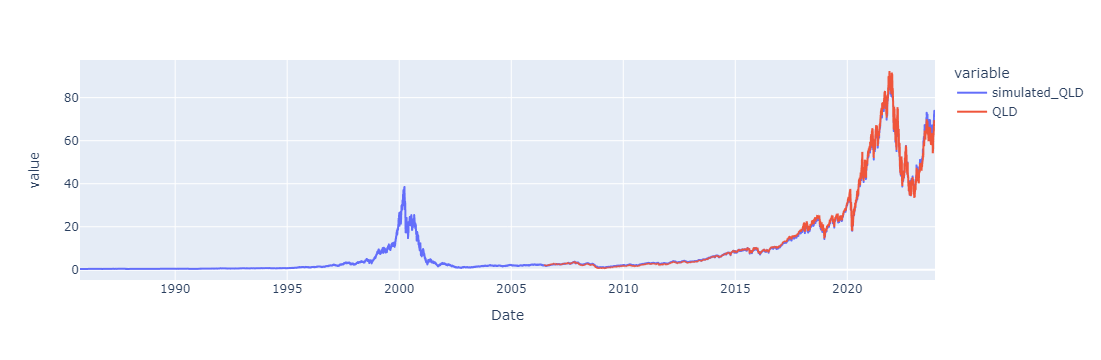

In [25]:
fig = px.line(
    final_result, x='Date', y=[
    'simulated_{}'.format(ETF_3x),
    ETF_3x])
fig.show()

final_result.plot(x ='Date', y=[
    'simulated_{}'.format(ETF_3x),
    ETF_3x,
    ], grid = True)

In [26]:
final_result.to_excel(
    '{}_simulation.xlsx'.format(ETF_3x),
    index = False,
    )

# END